In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
savePath = "../Results/logS/Prediction/LGBM/0.2.2_MRobust-2024-08-19_17.24.15_"
valData = pd.read_csv("../Data/Datasets/PredictionDatasets/0.2.2-logS-MRobust-ValidationSet.csv")
valPreds = pd.read_csv(f"{savePath}ValidationPreds.csv")

In [3]:
valData = valData[["logS", "InChI", "nIsomers", "logS-dataSource", "Temperature"]] #Change variables here for logS
valData

,logS,InChI,nIsomers,logS-dataSource,Temperature
0,-1.819281,"InChI=1S/3C2H5.ClH.Pb/c3*1-2;;/h3*1H2,2H3;1H;/...",1.0,"Lowe et al, 2023",0.0
1,-6.719655,InChI=1S/3C6H11.C2H2N3.Sn/c3*1-2-4-6-5-3-1;1-3...,1.0,"Lowe et al, 2023",0.0
2,-4.761253,"InChI=1S/4C4H9.Sn/c4*1-3-4-2;/h4*1,3-4H2,2H3;",1.0,"AqSolDB + IUPAC SDS + DDB 2023, Lowe et al 2023",0.0
3,-4.126098,InChI=1S/4CH3.Pb/h4*1H3;,1.0,"Lowe et al, 2023",0.0
4,-7.882463,"InChI=1S/6C10H13.O.2Sn/c6*1-10(2,3)9-7-5-4-6-8...",1.0,"Lowe et al, 2023",0.0
...,...,...,...,...,...
2552,-1.473943,InChI=1S/CO2/c2-1-3,1.0,"Lowe et al, 2023",0.0
2553,-1.690370,InChI=1S/COS/c2-1-3,1.0,"Lowe et al, 2023",0.0
2554,-1.843666,InChI=1S/CS2/c2-1-3,1.0,"AqSolDB + IUPAC SDS + DDB 2023, Lowe et al 2023",0.0
2555,-5.250000,InChI=1S/H3N/h1H3,1.0,AqSolDB + IUPAC SDS + DDB 2023,0.0


In [4]:
def calcMSE(yTrue, yPred):
    mse = [mean_squared_error(yT, yP) for yT, yP in zip(yTrue, yPred)]
    return mse

def unlog(x):
    return np.exp(x)

In [5]:
valData.insert(1, "logSPreds", valPreds["yPred"])

yPred = valData["logSPreds"].values.reshape(-1, 1)
yTrue = valData["logS"].values.reshape(-1, 1)

mse = calcMSE(yTrue, yPred)

valData.insert(2, "MSE", mse)

loggedR2 = r2_score(yTrue, yPred)
loggedMSE = mean_squared_error(yTrue, yPred)
valData.to_csv(f"{savePath}ValidationMSE.csv", index=False)

In [6]:
print("Logged R2: ", loggedR2)
print("Logged MSE: ", loggedMSE)

numEntries = valData.shape[0]
numErrorLogged = valData[valData["MSE"] > 1]

percentageErrorLogged = numErrorLogged.shape[0] / numEntries * 100
print("Percentage of entries with MSE > 1 (Logged): ", percentageErrorLogged)

Logged R2:  0.7360574017608497
Logged MSE:  1.845122192303419
Percentage of entries with MSE > 1 (Logged):  45.52209620649199


In [7]:
overallStats = pd.DataFrame([loggedR2, loggedMSE, percentageErrorLogged]).T
overallStats.columns = ["R2", "MSE", "PercentageError"]

overallStats.to_csv(f"{savePath}OverallStats.csv", index=False)

In [8]:
def getExtremes(target, df, nVals, ascend):
    entries = df.sort_values(by=target, ascending=ascend).head(nVals)
    inchi = entries["InChI"].values.tolist()
    scores = entries[target].values.tolist()

    return inchi, scores

def listExpander(myList, nVals): #Fill in list to desired length with nans
    if type(myList) != list:
        myList = [myList]
    for i in range(nVals - len(myList)):
        myList.append(np.nan)
    return myList

In [9]:
ascending = [True, False]
extreme = ["Best", "Worst"]
n = 10

for i in range(len(ascending)):
    asc = ascending[i]
    LoggedInChI, LoggedMSE = getExtremes("MSE", valData, n, asc)

    stats = pd.DataFrame([LoggedMSE, LoggedInChI]).T
    stats.columns = ["MSE", "InChI"]

    stats.to_csv(f"{savePath}{n}{extreme[i]}Entries.csv", index=False)

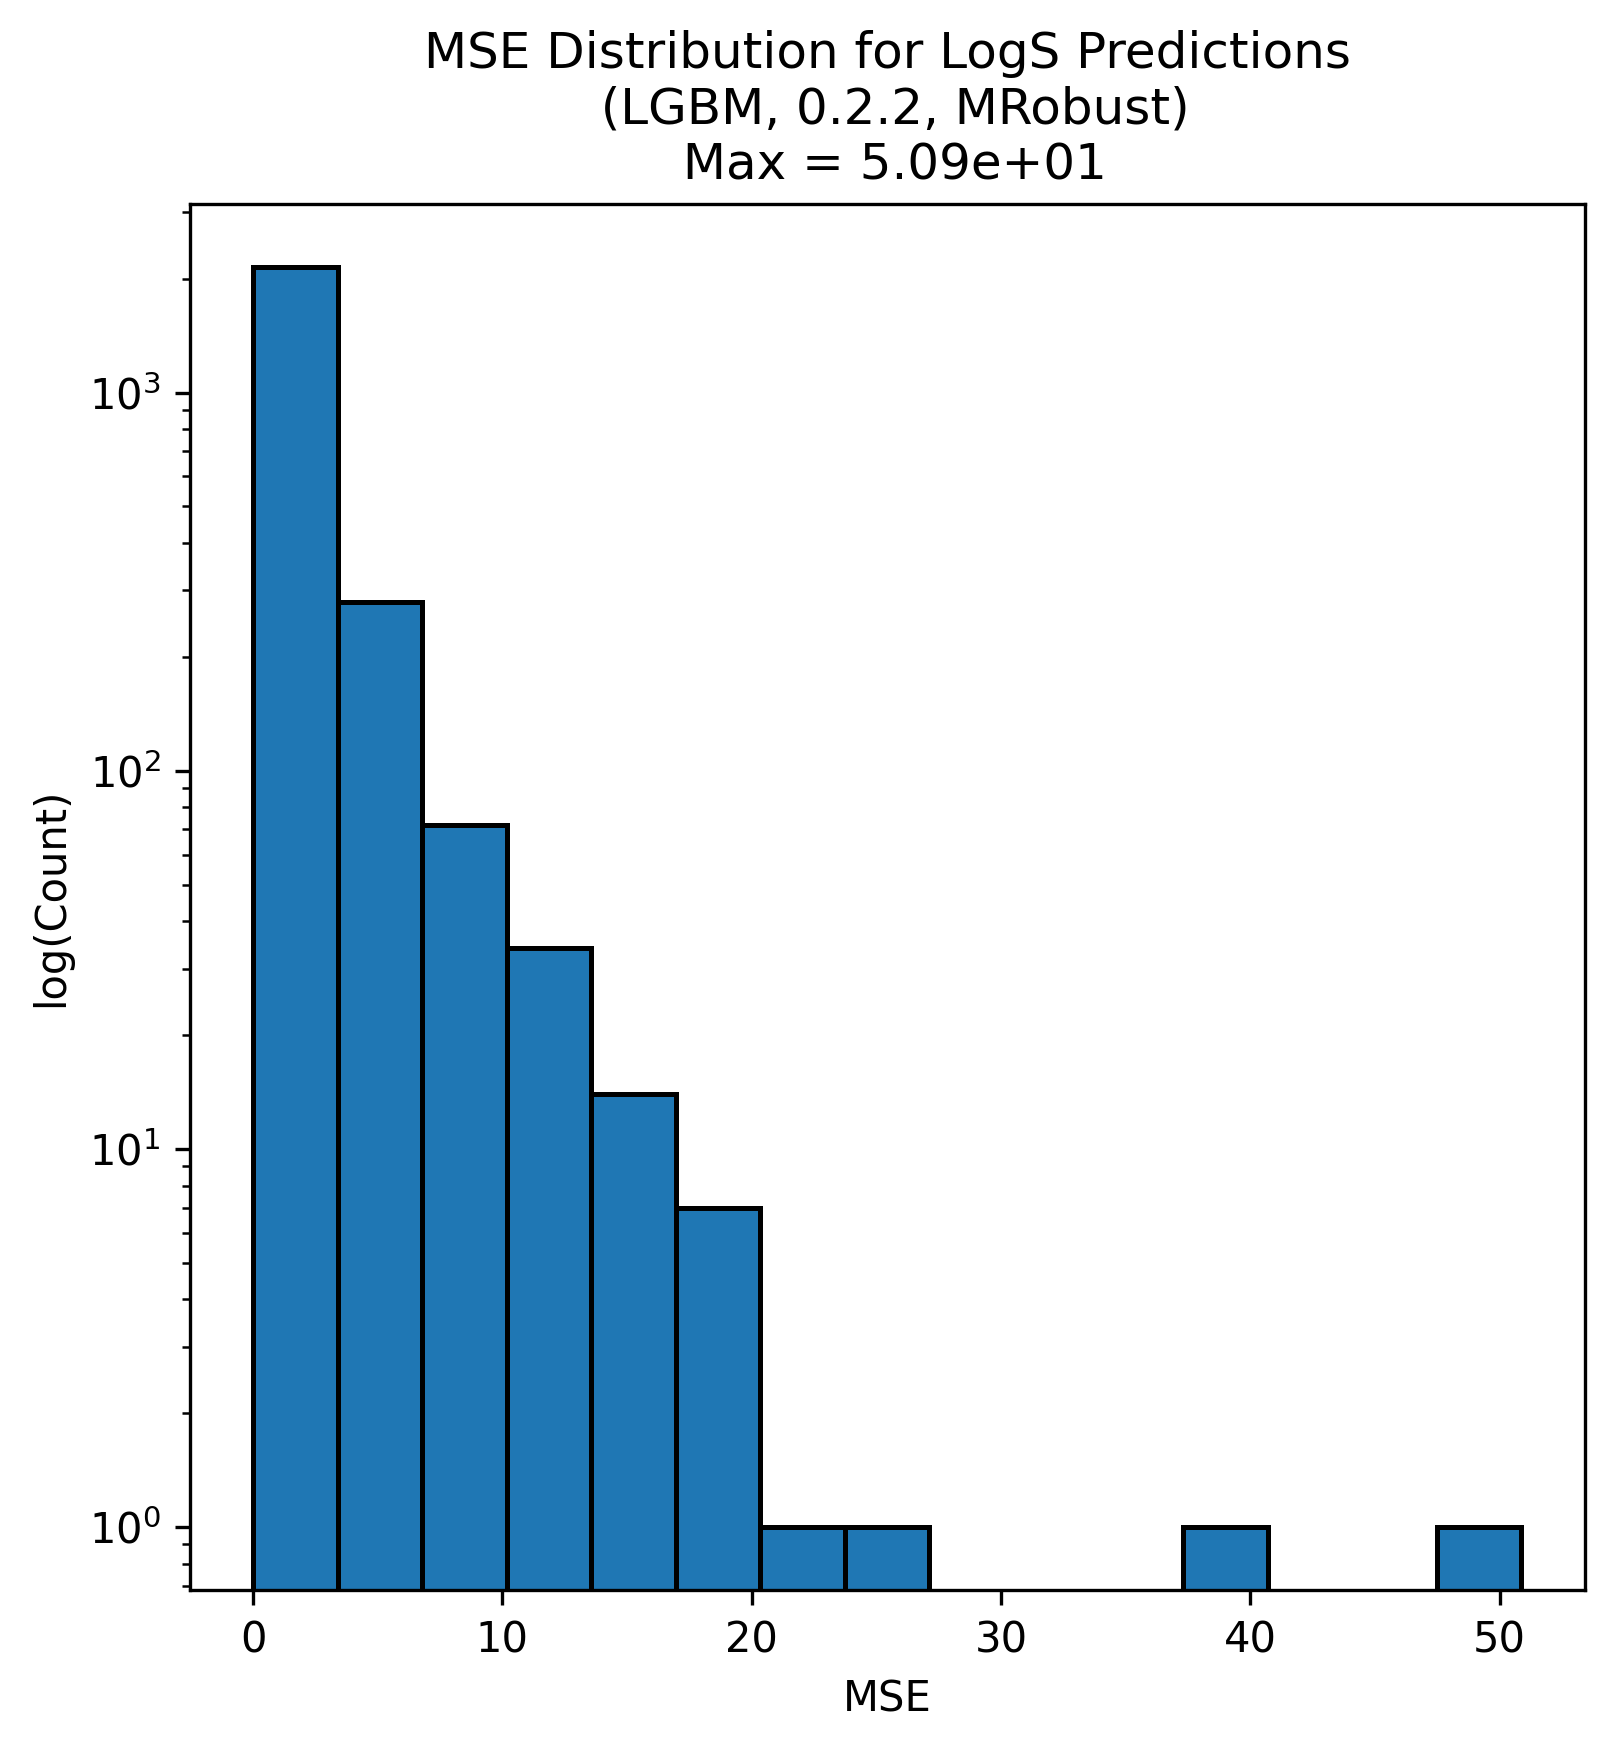

In [12]:
fig, ax = plt.subplots(figsize = (6, 6), dpi=300)
ax.hist(valData["MSE"], bins=15, edgecolor="black", linewidth=1.2)
ax.set_xlabel("MSE")
ax.set_ylabel("log(Count)")
ax.set_yscale("log")
ax.set_title(f"MSE Distribution for LogS Predictions\n (LGBM, 0.2.2, MRobust)\n Max = {np.max(mse):.2e}")
plt.show()